In [296]:
from __future__ import print_function
from collections import Counter
from collections import OrderedDict
import numpy as np
import numpy
import pandas as pd
from scipy import optimize
import matplotlib.mlab as mlab
import matplotlib.pyplot as plt
%matplotlib inline
import pickle
import calendar
import datetime
import re
from math import log
from scipy import stats
import nltk
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from array import array
from sklearn import preprocessing
from scipy.stats import boxcox
from scipy.stats import ttest_1samp, wilcoxon, ttest_ind, mannwhitneyu

In [252]:
#load the pickle object for quick access
result = pd.read_pickle("/Users/Matt/Documents/Stevens/BIA660 Web Analytics/yelp_dataset_challenge_academic_dataset/Data/500_Dataset")

In [256]:
#result.head()

In [333]:
def exploreBusiness(businessID):
    #exploratory Analysis for business ID mpDxBBGywUE6GRRKja3sBA
    business1 = result[result["business_id"]==businessID]
    #change date into datetime
    business1['date'] = pd.to_datetime(business1['date'])
    business1['Year-Month'] = business1.date.map(lambda x: x.strftime('%Y-%m'))
    business1['Qdate'] = [date - pd.tseries.offsets.DateOffset(days=1) + pd.tseries.offsets.QuarterEnd() for date in business1.date]
    #review_counts = business1.groupby('Year-Month')['review_id'].count()
    review_counts = business1.groupby('Qdate')['stars_x'].mean()
    #review_counts = review_counts.apply(lambda x: (x - x.mean()) / (x.max() - x.min()))
    #review_counts = review_counts[review_counts.apply(lambda x: np.abs(x - x.mean()) / x.std() < 3).all(axis=1)]
    #x = df.values #returns a numpy array
    #min_max_scaler = preprocessing.MinMaxScaler()
    #x_scaled = min_max_scaler.fit_transform(review_counts)
    #review_counts['review_id'] = x_scaled
    ax = review_counts.plot(kind='bar', figsize=(20,10))
    return review_counts, business1

In [377]:
#plt.hist(review_counts)
#stats.shapiro(review_counts)[1]
#anomaly, normal_data=Ttest_Anomaly_Detection(review_counts)
#anomaly

/Users/Matt/anaconda2/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/Matt/anaconda2/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/Matt/anaconda2/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydat

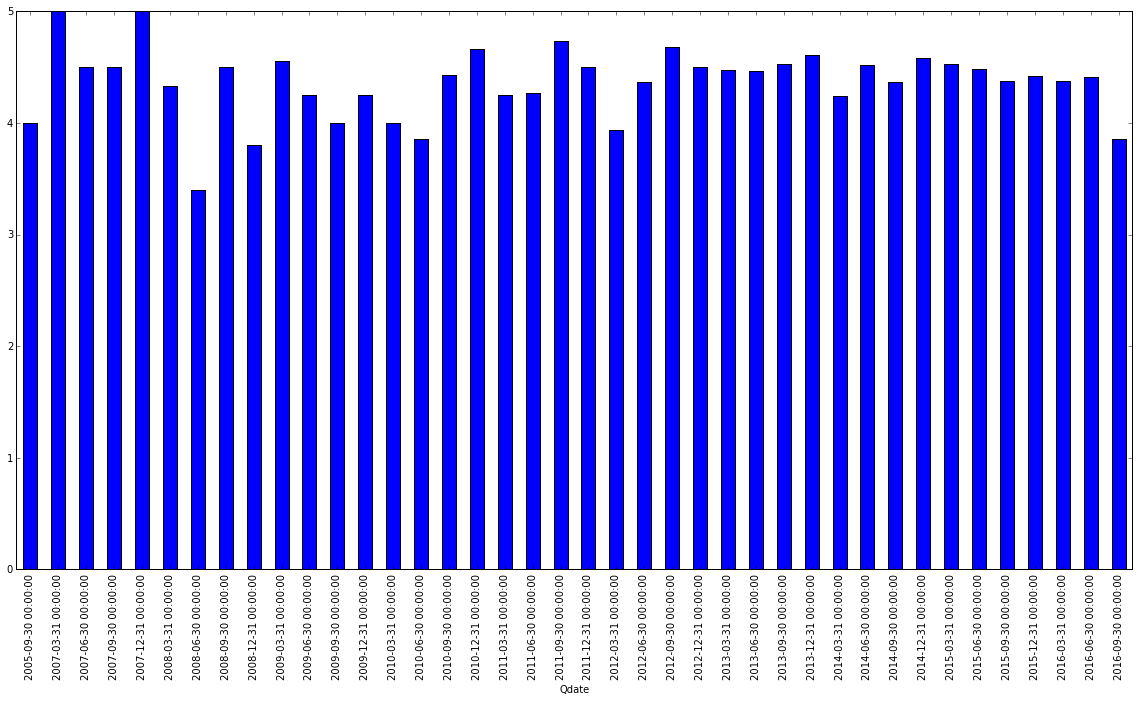

In [334]:
#review_counts, business_df = exploreBusiness('3Q0QQPnHcJuX1DLCL9G9Cg')
review_counts, business_df = exploreBusiness('Pgp3gbOQaJIdyjqC9AOz6g')


In [338]:
# runs a 1 sample t test to compare a new month with the previous months
# https://stats.stackexchange.com/questions/198825/compare-previous-month-to-all-other-previous-months-performance
# http://iaingallagher.tumblr.com/post/50980987285/t-tests-in-python
#if stats.shapiro(review_counts)[1] >0.05:
#    normal_data=1
def Ttest_Anomaly_Detection(review_counts):
    anomaly = OrderedDict() #initialize dict
    d = OrderedDict()
    normal_data=0
    if stats.shapiro(review_counts)[1] >0.05:
        normal_data=1
    #one_sample_data = review_counts.values
    for ind, value in review_counts.iteritems():
        d[ind] = value
        #anomaly[ind]=-1
        if len(d) >= 31: #need 30 samples because the data is non-normal
            #t-test to compare the next month/year sample to the mean of all the prior ones
            one_sample_data = d.values()[0:(len(d)-1)]
            one_sample = stats.ttest_1samp(one_sample_data,value) #compares the entire period
            #one_sample = stats.wilcoxon(one_sample_data-value)
            #print(ind,value, one_sample_data)
            #print(len(d))
            if one_sample.pvalue < 0.01: #null hypothesis: new sample = prior mean
                anomaly[ind]=1  #there is a statistically signifant difference, where the new sample != prior mean   
    return anomaly, normal_data

In [260]:
#locate the period where there is a change in the anomaly[ind] values
#returns a dict where an anomaly is coded as a 1
def choosePeriods(anomaly):
    period={}
    keylist = anomaly.keys()
    keylist.sort()
    for key in keylist:
        if anomaly[key] == 1:
            period[key]=1
        else:
            period[key]=0
    return period   

In [347]:
#show a summary of the top words of ALL the anomalies for a given business
def textAnalysis_of_Anomaly(business_df, business_id, period):
    common={}
    final=''
    keylist = period.keys()
    keylist.sort()
    words_test=[]
    for key in keylist:
        if period[key] == 1:
            text=business_df[(business_df['Qdate']==key)].text
            text=text.to_string()
            text = re.sub('\W+', ' ',text)
            default_stopwords = set(nltk.corpus.stopwords.words('english'))
            custom_stopwords = set((u'–', '...'))
            all_stopwords = default_stopwords | custom_stopwords
            words = nltk.word_tokenize(text)

            words = [word for word in words if len(word) > 2] #remove words that are only 1 character
            # Remove numbers
            words = [word for word in words if not word.isnumeric()]

            # Lowercase all words (default_stopwords are lowercase too)
            words = [word.lower() for word in words]

            #remove words that are stopwords
            words = [word for word in words if word not in all_stopwords]
            words_test += words

    #print(words_test)
    # Calculate frequency distribution
    fdist = nltk.FreqDist(words_test)

    for word, frequency in fdist.most_common(10):
        final+=str(word+' ')
    common[business_id] = final

    return common

In [345]:
#outputs the most common words for each anomaly found for a business
def getCommonWordsForEachAnomaly(business_df, business_id, period):
    common={}
    keylist = period.keys()
    keylist.sort()
    for key in keylist:
        final=''
        if period[key] == 1:
            text=business_df[(business_df['Qdate']==key)].text
            text=text.to_string()
            text = re.sub('\W+', ' ',text)
            default_stopwords = set(nltk.corpus.stopwords.words('english'))
            custom_stopwords = set((u'–', '...'))
            all_stopwords = default_stopwords | custom_stopwords
            words = nltk.word_tokenize(text)
            
            words = [word for word in words if len(word) > 2] #remove words that are only 1 character
            # Remove numbers
            words = [word for word in words if not word.isnumeric()]

            # Lowercase all words (default_stopwords are lowercase too)
            words = [word.lower() for word in words]

            #remove words that are stopwords
            words = [word for word in words if word not in all_stopwords]

            # Calculate frequency distribution
            fdist = nltk.FreqDist(words)
            
            for word, frequency in fdist.most_common(5):
                final+=str(word+' ')
        common[key] = final
    
    return business_id, common

In [268]:
anomaly = Ttest_Anomaly_Detetion(review_counts)
if len(anomaly)>0:
    period = choosePeriods(anomaly)
    getCommonWordsForEachAnomaly(business_df,'Pgp3gbOQaJIdyjqC9AOz6g',period)

In [287]:
#results[(results.business_id=='3Q0QQPnHcJuX1DLCL9G9Cg') && (results.date==period[key])]
#text=business_df[(business_df.business_id=='3Q0QQPnHcJuX1DLCL9G9Cg') & (business_df['Year-Month']=='2010-09')].text


/Users/Matt/anaconda2/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/Matt/anaconda2/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


{u'3Q0QQPnHcJuX1DLCL9G9Cg': 'airport charlotte nice always clean layover great one time airports '}
{u'qMkIbQFrROSnPaQ7at85-w': 'place beautiful desert great botanical really first garden gardens years '}
{u'AkOruz5CrCxUmXe1p_WoRg': 'place food great love ramen good cherry favorite japanese one '}
{u'rDvz5jX65gpfONFu7er9Tw': 'food best tacos great mexican place good street burritos delicious '}
{u'wZwZcte4lcbu51NOzCjWbQ': 'food place great view service went atmosphere fun dinner good '}
{u'FV16IeXJp2W6pnghTz2FAw': 'pho place food service best good vegas always long great '}
{u'Yq8LiVymGA7vBpGCQuDfRw': 'pho place service vegas food best good one time great '}
{u'eoDEx1GGQA0CBDhy2ql_Kw': 'place food breakfast service great excellent good like old school '}
{u'w4SGmsvFzqyAIs7CSQ_J-g': 'donuts place vegan donut great best love doughnuts shop amazing '}
{u'bqYrEwL5xjqv0u8XAij--Q': 'tea place boba station service good love food come milk '}
{u'uYVdp5LfCbX8S8ytnhdk-g': 'place luv custard love

/Users/Matt/anaconda2/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


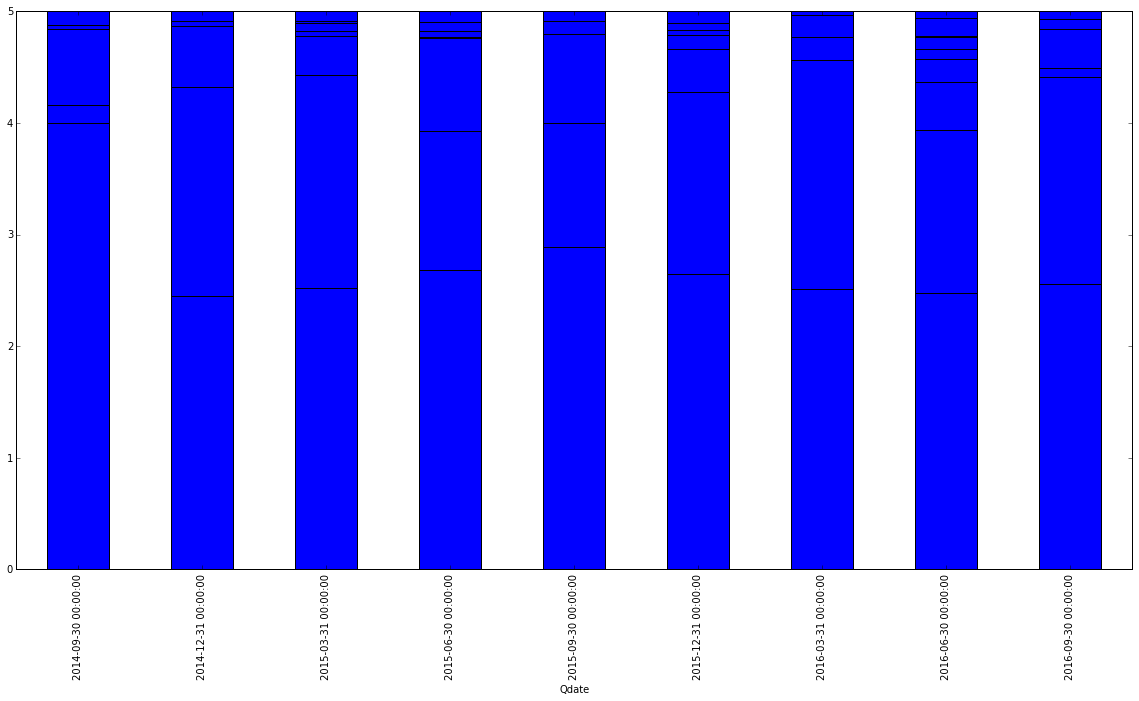

In [349]:
for business in result.business_id.unique():
    common={}
    business_id = business
    review_counts, business_df = exploreBusiness(business)
    anomaly, normal_data = Ttest_Anomaly_Detection(review_counts)
    if len(anomaly)> 1 and normal_data == 1:
        period = choosePeriods(anomaly)
        print(textAnalysis_of_Anomaly(business_df,business_id,period))